In [1]:
import torch
import torchaudio

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cpu


In [4]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'co

In [5]:
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

In [6]:
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [7]:
waveform, sr = torchaudio.load('./2056002088.wav', normalize=True)
sample_rate = 22050
waveform = torchaudio.functional.resample(waveform[0].unsqueeze(0), sr, sample_rate)
waveform.shape

torch.Size([1, 53234])

In [8]:
torch.log2(torch.tensor(65536))

tensor(16.)

In [9]:
waveform = torch.concat([waveform, torch.zeros([1, int(2**torch.ceil(torch.log2(torch.tensor(waveform.size(1)))))-waveform.shape[1]])],dim=-1)
waveform.shape

torch.Size([1, 65536])

In [13]:

transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
    n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
        f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")

# fft = torchaudio.transforms.Spectrogram(
#     n_fft=1024,
#     power=1,
#     hop_length=256,
#     win_length=1024,
# )
# mel = torchaudio.transforms.MelScale(
#     n_stft=(1024 // 2 + 1),
#     n_mels=80,
#     sample_rate=sample_rate,
#     f_min=0.0,
#     f_max=8000.0,
#     mel_scale="slaney",
#     norm="slaney",
# )
# f_out = fft(waveform)
# mel_out = mel(f_out)
mel_out = transform(waveform)
log_out = torch.log(mel_out+2**(-15))

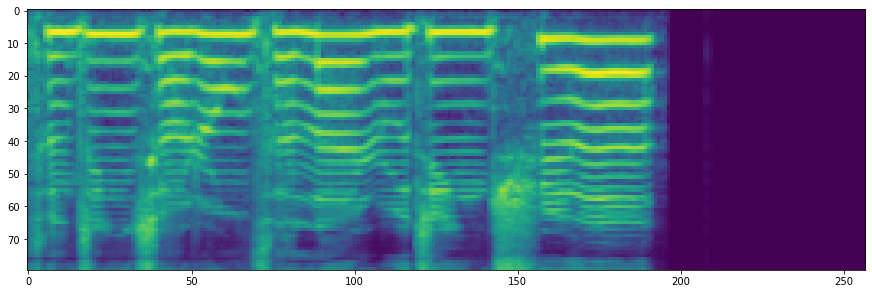

In [14]:
plt.imshow(log_out[0])

In [89]:
i_mel = torchaudio.transforms.InverseMelScale(
            n_stft=(1024 // 2 + 1),
            n_mels=80,
            sample_rate=sample_rate,
            f_min=0.0,
            f_max=8000.0,
            mel_scale="slaney",
            norm="slaney",
        )
gl = torchaudio.transforms.GriffinLim(
            n_fft=1024,
            power=1,
            hop_length=256,
            win_length=1024,
        )

def check_diff(a, b):
    return (a-b).abs().sum()
exp_out = torch.exp(log_out)
check_diff(exp_out, mel_out)

tensor(1.1353e-05)

In [50]:
from torchaudio.pipelines._tts.impl import _GriffinLimVocoder
gv = _GriffinLimVocoder()
# wave_restore = gv(mel_specgram)

In [52]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /home/bh2283/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

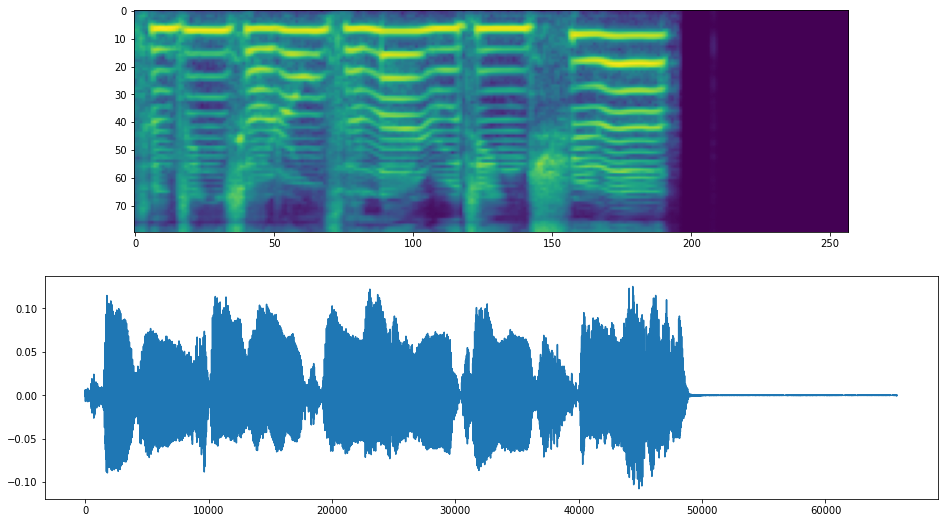

In [15]:
spec = log_out
with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
# IPython.display.Audio("_assets/output_waveglow.wav")

# 几乎完美